In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision

# Implementing LeNet

* In 1998, **LeNet** was among the first published convolutional neural networks to gather wide attention for its performance on computer vision tasks. In this lab session, you will use high-level PyTorch functionalities to implement the LeNet convolutional neural network.

* You will use the [fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, which is composed of labeled images of clothes and accessories.

* The following function is used to load the dataset. You don't need to understand it for now.


In [ ]:
# You don't need to understand this function for now.
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [torchvision.transforms.ToTensor()]
    if resize:
        trans.insert(0, torchvision.transforms.Resize(resize))
    trans = torchvision.transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

In [ ]:
batch_size = 256 # Defines the batch size
train_iter, test_iter = load_data_fashion_mnist(batch_size) # Loads the fashion MNIST dataset. `train_iter` and `test_iter` are `DataLoader` objects.

In [ ]:
X, y = next(iter(train_iter)) # Requests the first training batch
print(X.size()) # 256 images per batch. Each image is represented by a 1 x 28 x 28 tensor (number of channels x height x width). The images are grayscale, so there is a single channel.
print(y.size()) # 256 targets. Each target is a number between 0 and 9. The classification problem has 10 clases.

torch.Size([256, 1, 28, 28])
torch.Size([256])


* The following code displays some images from the first training batch.


In [ ]:
from google.colab.patches import cv2_imshow

class_labels = ['top', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'boot'] # Pre-defined class labels

for i in range(3):
    print(f'\nImage {i} ({class_labels[int(y[i])]}):\n') # Prints the index `i` and the label associated to the `i`-th image.
    cv2_imshow(X[i].numpy().transpose(1, 2, 0) * 255) # Converts and displays the `i`-th image in the batch.


Image 0 (top):




Image 1 (dress):




Image 2 (sandal):



## Architecture

* The architecture receives a $1 \times 28 \times 28$ image and outputs a vector with $10$ elements.  The following layers are employed:
   * A convolutional layer with $6$ kernels, each a $1 \times 5 \times 5$ tensor, padding $2$, stride $1$, and a sigmoid activation function. **Output**: a $6 \times 28 \times 28$ tensor.
   * An average pooling layer with windows of size $2 \times 2$ and stride $2$. **Output**: a $6 \times 14 \times 14$ tensor.
   * A convolutional layer with $16$ kernels, each a $6 \times 5 \times 5$ tensor, padding $0$, stride $1$, and a sigmoid activation function. **Output**: a $16 \times 10 \times 10$ tensor.
   * An average pooling layer with windows of size $2 \times 2$ and stride $2$. **Output**: a $16 \times 5 \times 5$ tensor.
   * A fully connected layer wih $120$ units and a sigmoid activation function. The input is flatenned into a vector with $16 \cdot 5 \cdot 5 = 400$ elements. **Output**: a vector with $120$ elements.
   * A fully connected layer with $84$ units and a sigmoid activation function. **Output**: a vector with $84$ elements.
   * A fully connected layer with $10$ units and a softmax activation function **Output**: a vector with $10$ elements. *Note: the original LeNet used a so-called Gaussian activation layer, which is currently rarely used.*

![LeNet-5 architecture.](https://drive.google.com/uc?export=view&id=1qht6z0oT0TGBYQl-aLiSRhBaPINi4rzE)

* The class `torch.nn.Module` requires implementing the method `forward`, which should define the forward pass for a batch of images.
    * Because the batch size was set to $256$, a batch of images is represented by a $256 \times 1 \times 28 \times 28$ tensor.
    * The method `forward` should compute the $256 \times 10$ logits matrix $\mathbf{O}$, not the prediction matrix $\mathbf{\hat{Y}} = \text{softmax}(\mathbf{O})$. In other words, the last fully connected layer does not need an (explicit) softmax activation function.




In [ ]:
class LeNet(torch.nn.Module):
    def __init__(self, num_outputs):
        super(LeNet, self).__init__()
        self.num_outputs = num_outputs

        self.Sigmoid = torch.nn.Sigmoid()

        self.Convl1 = torch.nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.Avg1 = torch.nn.AvgPool2d(2, stride=2)
        self.Convl2 = torch.nn.Conv2d(6, 16, kernel_size=5, padding=0)
        self.Avg2 = torch.nn.AvgPool2d(2, stride=2)

        self.Flatten = torch.nn.Flatten()
        self.Linear1 = torch.nn.Linear(400, 120)
        self.Linear2 = torch.nn.Linear(120, 84)
        self.Linear3 = torch.nn.Linear(84, self.num_outputs)

    def forward(self, x):
        out = self.Convl1(x)
        out = self.Sigmoid(out)
        out = self.Avg1(out)
        out = self.Convl2(out)
        out = self.Sigmoid(out)
        out = self.Avg2(out)
        out = self.Flatten(out)
        out = self.Linear1(out)
        out = self.Sigmoid(out)
        out = self.Linear2(out)
        out = self.Sigmoid(out)
        out = self.Linear3(out)
        return out

In [ ]:
# Applies Xavier initialization if the `torch.nn.Module` is `torch.nn.Linear` or `torch.nn.Conv2d`
def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

num_outputs = 10
model = LeNet(num_outputs)
model.apply(init_weights) # Applies `init_weights` to every `torch.nn.Module` inside `model`

LeNet(
  (Sigmoid): Sigmoid()
  (Convl1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Avg1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (Convl2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (Avg2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (Linear1): Linear(in_features=400, out_features=120, bias=True)
  (Linear2): Linear(in_features=120, out_features=84, bias=True)
  (Linear3): Linear(in_features=84, out_features=10, bias=True)
)

## Loss function

* The *convolutional neural network* defined above computes the logits matrix $\mathbf{O}$, not the prediction matrix $\mathbf{\hat{Y}} = \text{softmax}(\mathbf{O})$.

* This is because PyTorch provides a class called `CrossEntropyLoss` that implements the desired cross entropy loss but requires a logits matrix $\mathbf{O}$ instead of the prediction matrix $\mathbf{\hat{Y}}$.

* The class `CrossEntropyLoss` implements the cross entropy loss in a way that avoids numerical instabilities that would result from a naive implementation.

In [ ]:
loss = torch.nn.CrossEntropyLoss()

## Optimization Algorithm

* We will employ minibatch stochastic gradient descent with a learning rate of $0.9$ as the optimization algorithm.

* Because we implemented a subclass of `torch.nn.Module`, the model parameters can be accessed through the method `parameters`.

In [ ]:
lr = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## Evaluation

* Recall that the highest element of a logits vector determines which class will be predicted.

* We can use this to compute the number of correct predictions per batch.

In [ ]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

# Example: 1 correct classification,
y = torch.tensor([2, 1])
logits = torch.tensor([[0.1, 0.3, 0.6], [0.5, 0.2, 0.3]])
print(correct(logits, y))

tensor(1.)


* We can use the previous function to compute the accuracy of our model in a given dataset by accumulating the number of correct predictions across batches and then dividing that number by the number of examples in the dataset.

In [ ]:
def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0.)
    n = torch.tensor(0.)
    for X, y in data_iter:
        logits = model(X)
        c += metric(logits, y)
        n += len(y)

    return c / n

In [ ]:
print(f'Training accuracy: {evaluate_metric(model, train_iter, correct)}. Testing accuracy: {evaluate_metric(model, test_iter, correct)}.')

Training accuracy: 0.10000000149011612. Testing accuracy: 0.10000000149011612.


## Training

* The following code implements the training loop for the convolutional neural network.

* The training/testing dataset accuracy is displayed after each epoch and stored for plotting.

* **Important:** it is a methodological mistake to compute performance metrics on the *testing* dataset for the purposes of hyperparameter tuning. A *validation* dataset should be used for that purpose, even if it requires splitting the original training dataset into a training dataset and a validation dataset. The *test* dataset should only be used to evaluate the performance of the final set of hyperparameters, in order to assess generalization.


Epoch 1/20.
Training accuracy: 0.1000666692852974. Testing accuracy: 0.10010000318288803.

Epoch 2/20.
Training accuracy: 0.5920000076293945. Testing accuracy: 0.5927000045776367.

Epoch 3/20.
Training accuracy: 0.6699000000953674. Testing accuracy: 0.6656000018119812.

Epoch 4/20.
Training accuracy: 0.7182333469390869. Testing accuracy: 0.7153000235557556.

Epoch 5/20.
Training accuracy: 0.7523166537284851. Testing accuracy: 0.744700014591217.

Epoch 6/20.
Training accuracy: 0.7738333344459534. Testing accuracy: 0.7623000144958496.

Epoch 7/20.
Training accuracy: 0.8049333095550537. Testing accuracy: 0.8004000186920166.

Epoch 8/20.
Training accuracy: 0.8150500059127808. Testing accuracy: 0.8044000267982483.

Epoch 9/20.
Training accuracy: 0.7628166675567627. Testing accuracy: 0.7569000124931335.

Epoch 10/20.
Training accuracy: 0.8149666786193848. Testing accuracy: 0.7993000149726868.

Epoch 11/20.
Training accuracy: 0.8088333606719971. Testing accuracy: 0.7964000105857849.

Epoch 1

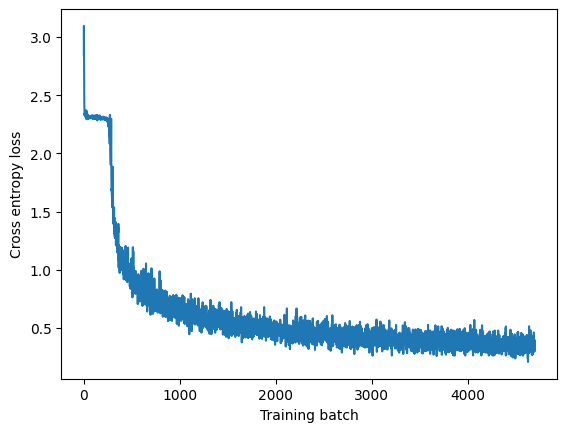

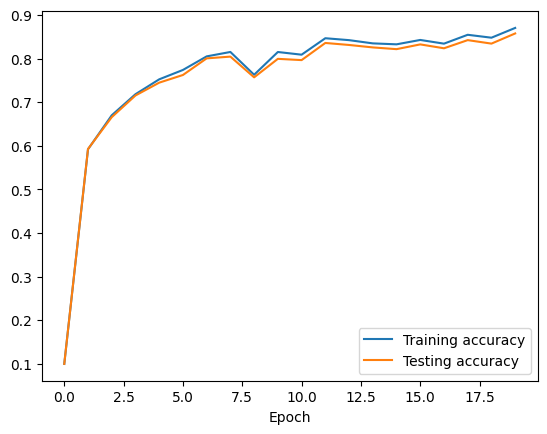

In [ ]:
losses = [] # Stores the loss for each training batch
train_accs = [] # Stores the training accuracy after each epoch
test_accs = [] # Stores the testing accuracy after each epoch

num_epochs = 20
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    for X, y in train_iter:
        logits = model(X) # Computes the logits for the batch of images `X`

        l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
        optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
        l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

        optimizer.step() # Updates the model parameters based on the gradients stored inside them

        losses.append(float(l)) # Stores the loss for this batch

    with torch.no_grad(): # Computing performance metrics does not require gradients
        train_accs.append(evaluate_metric(model, train_iter, correct))
        test_accs.append(evaluate_metric(model, test_iter, correct))
        print(f'Training accuracy: {train_accs[-1]}. Testing accuracy: {test_accs[-1]}.') # Computes and displays training/testing dataset accuracy.

plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()